In [15]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure

import random
import copy
import math
import cv2
import os

# TRAINED MODELS
## Loading of the models

In [16]:
# model = tf.keras.models.load_model('IRI_models/16set_8px_steps_only_paths')

# model1 = tf.keras.models.load_model('IRI_models/16set_8px_steps_only_vels')

# model2 = tf.keras.models.load_model('IRI_models/16set_8px_steps_only_stops')

# Variables definition

In [17]:
div = 32
step = int(32/4)
red = [2,2,2,2,2,2]

sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']
chans = len(sem_dict)+1

lut_in = [0, 20, 50, 100, 150, 255]
lut_out = [0, 100, 180, 220, 240, 255]
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

## Model 1 testing

master_big
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


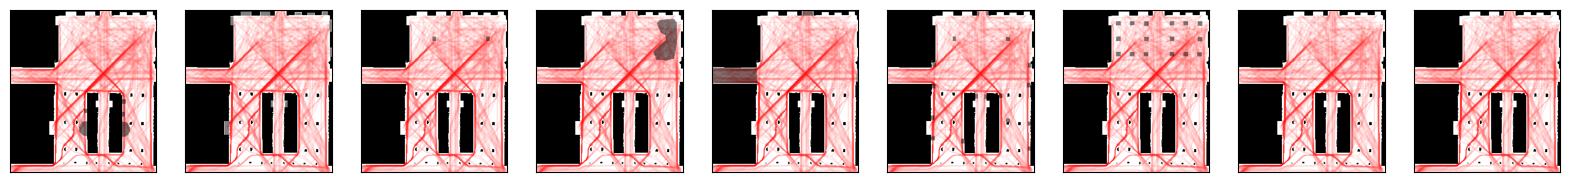

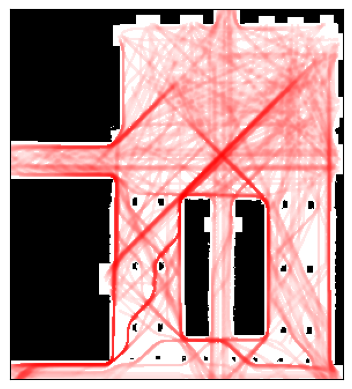

willow
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


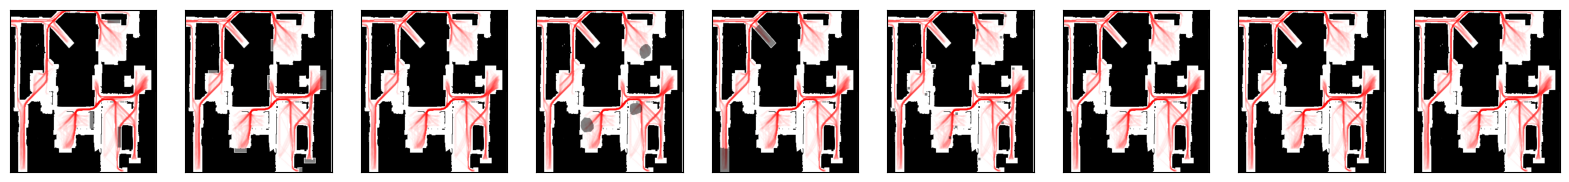

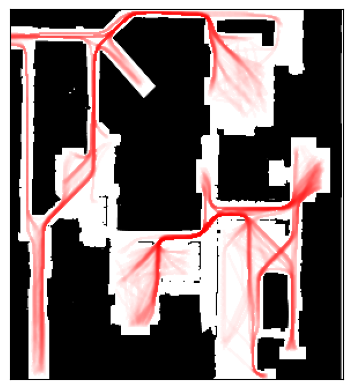

costacafe
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


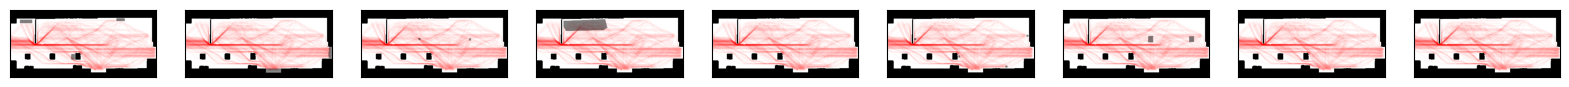

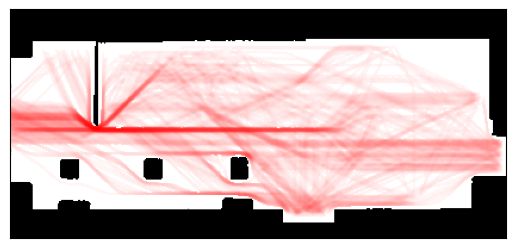

map1
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


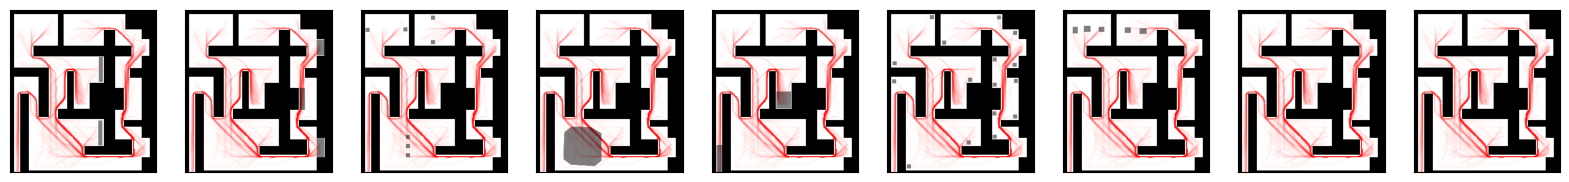

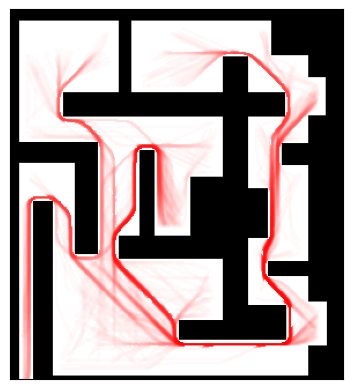

map2
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


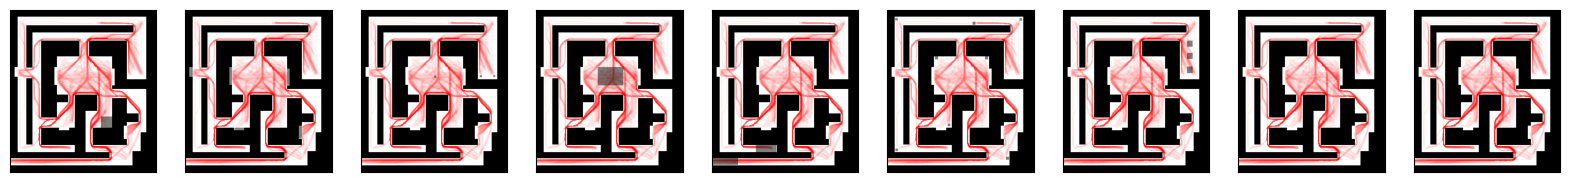

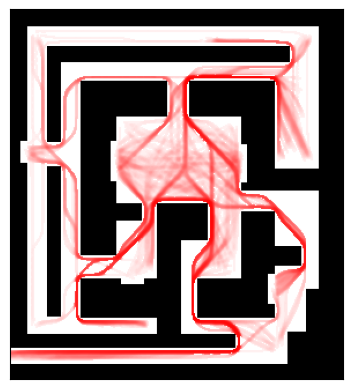

map3
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


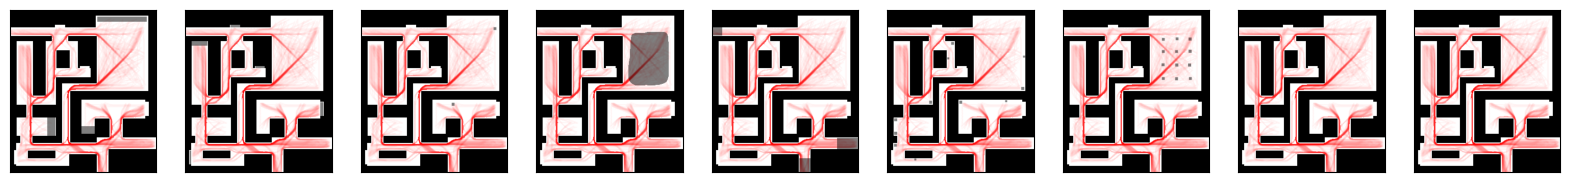

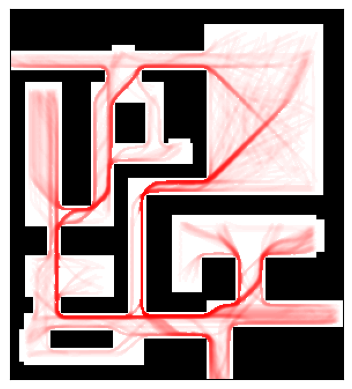

Mean KL-divergence: nan


In [18]:
map_list = ['master_big','willow','costacafe','map1','map2','map3']
kl1 = []

for map_count, map_name in enumerate(map_list):
  print(map_name)

  lines = 0
  with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])

    except FileNotFoundError:
      for i in range(h):
        for j in range(w):
          map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red[map_count])),int(math.ceil(w/red[map_count])),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red[map_count],red[map_count]), np.max)
  h, w, _ = map.shape

  diff_h = int((h-div*int(h/div))/2)
  r_h = int((h-div*int(h/div))%2) + diff_h
  diff_w = int((w-div*int(w/div))/2)
  r_w = int((w-div*int(w/div))%2) + diff_w
  map = map[r_h:-diff_h:,r_w+diff_w:,:]

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 2.0
  data = skimage.filters.gaussian(data+(data==0), sigma=(sigma, sigma), channel_axis=-1)*(data>0)
  data = skimage.measure.block_reduce(data, (red[map_count],red[map_count]), np.max)
  data = data[r_h:-diff_h,r_w+diff_w:]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    i = i+1
    ax = plt.subplot(1, len(sem_dict), i)
    alp = 0.5
    contrasted_data = cv2.LUT((data/np.max(data)*255).astype(np.uint8), lut_8u).astype(float)/255
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(contrasted_data.shape,1),1-contrasted_data,1-contrasted_data),axis=2))), vmin=0, vmax=1)
    # ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(data.shape,1),1-data,1-data),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  contrasted_data = cv2.LUT((data/np.max(data)*255).astype(np.uint8), lut_8u).astype(float)/255
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(contrasted_data.shape,1),1-contrasted_data,1-contrasted_data),axis=2)), vmin=0, vmax=1)
  # ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # # -----------------------------------------------------------------------------------
  # # creating subplot and figure
  # ax = plt.subplot(111)
  # data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  # step = int(32/4)
  # for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
  #   c = int(i%(w/step+int(div/step-1))) - int(div/step-1)
  #   r = int(i/(w/step+int(div/step-1))) - int(div/step-1)
  #   submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
  #   subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
  #   subdata = np.squeeze(subdata,axis=0)
  #   data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
  # contrasted_data = cv2.LUT((data_pred/np.max(data_pred)*255).astype(np.uint8), lut_8u).astype(float)/255
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(contrasted_data.shape,1),1-contrasted_data,1-contrasted_data),axis=2)), vmin=0, vmax=1)
  # # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
  # ax.get_xaxis().set_visible(False)
  # ax.get_yaxis().set_visible(False)
  # plt.show()

  # data = data/sum(sum(data))
  # data_pred = data_pred/sum(sum(data_pred))
  # kl = 0
  # for i in range(data.shape[0]):
  #     for j in range(data.shape[1]):
  #         if data[i,j] > 0 and data_pred[i,j] > 0:
  #             kl = kl + data[i,j]*math.log2(data[i,j]/data_pred[i,j])
  # print(f'KL-divergence: {kl}')
  # kl1 = np.append(kl1,kl)

print(f'Mean KL-divergence: {np.mean(kl1)}')

## Model 2 testing

master_big
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


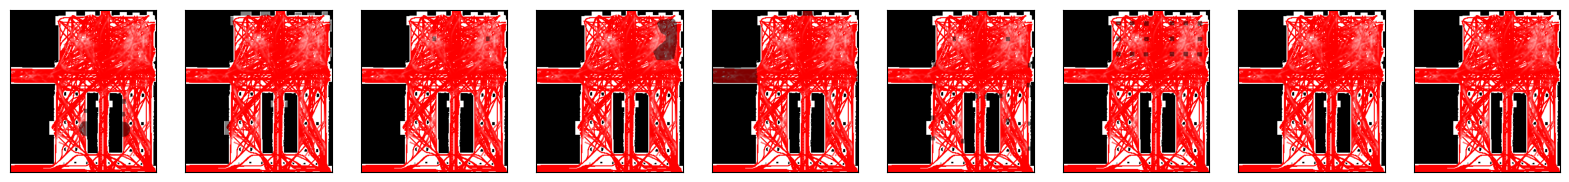

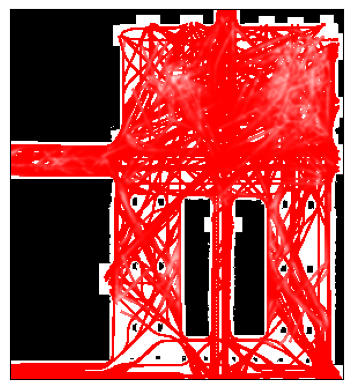

willow
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


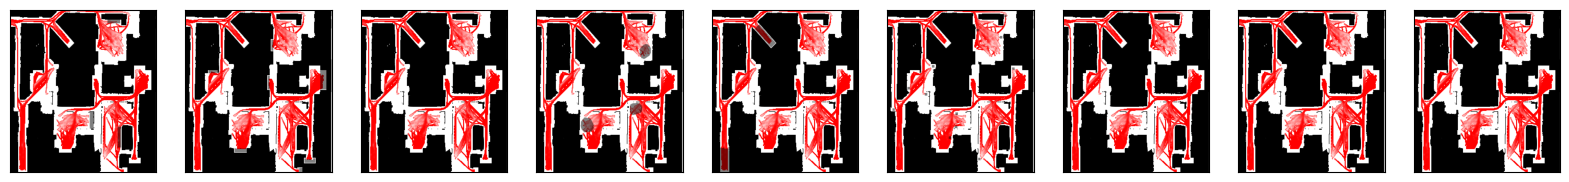

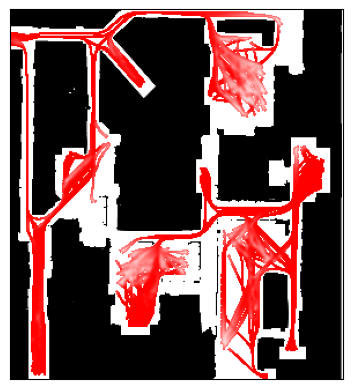

costacafe
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


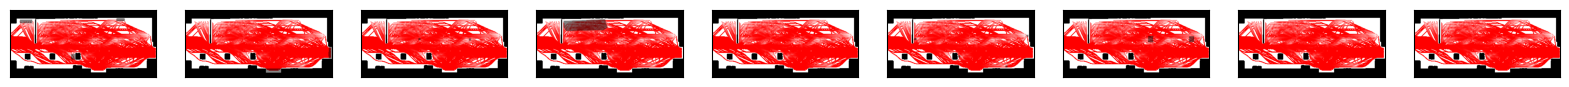

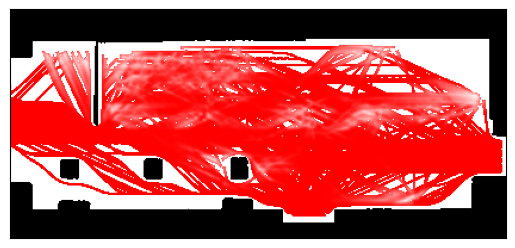

map1
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


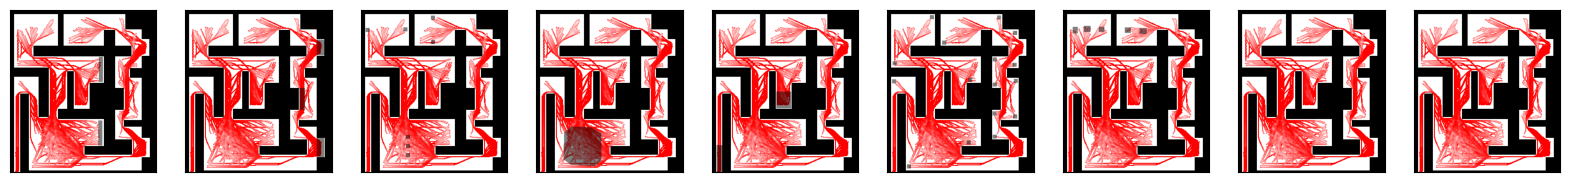

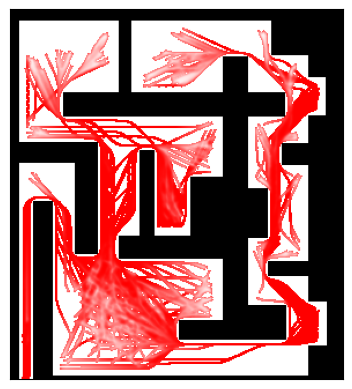

map2
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


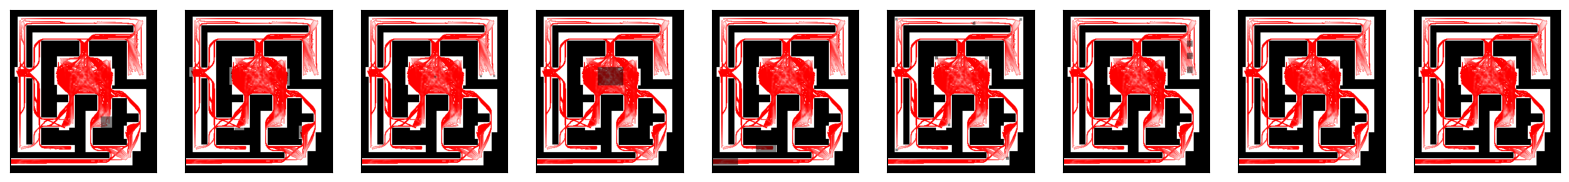

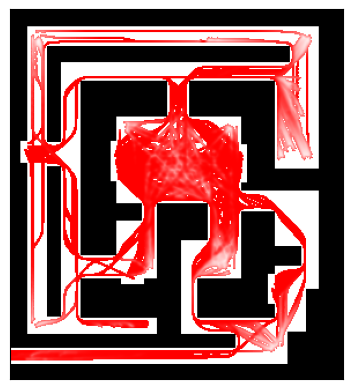

map3
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


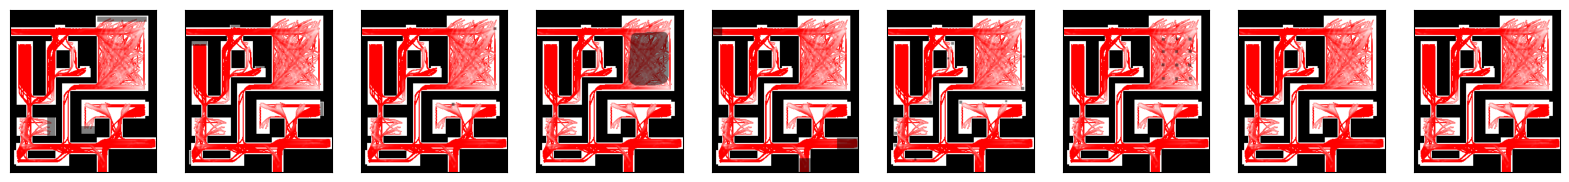

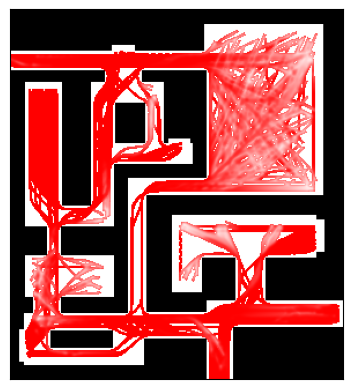

Mean KL-divergence: nan


In [19]:
kl1 = []

for map_count, map_name in enumerate(map_list):
  print(map_name)

  lines = 0
  with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])

    except FileNotFoundError:
      for i in range(h):
        for j in range(w):
          map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red[map_count])),int(math.ceil(w/red[map_count])),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red[map_count],red[map_count]), np.max)
  h, w, _ = map.shape

  diff_h = int((h-div*int(h/div))/2)
  r_h = int((h-div*int(h/div))%2) + diff_h
  diff_w = int((w-div*int(w/div))/2)
  r_w = int((w-div*int(w/div))%2) + diff_w
  map = map[r_h:-diff_h:,r_w+diff_w:,:]

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-vel.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([float(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 2.0
  data = skimage.filters.gaussian(data+(data==0), sigma=(sigma, sigma), channel_axis=-1)*(data>0)
  data = skimage.measure.block_reduce(data, (red[map_count],red[map_count]), np.max)
  data = data[r_h:-diff_h,r_w+diff_w:]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    i = i+1
    ax = plt.subplot(1, len(sem_dict), i)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(data.shape,1),1-data,1-data),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # # -----------------------------------------------------------------------------------
  # # creating subplot and figure
  # ax = plt.subplot(111)
  # data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  # step = int(32/4)
  # for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
  #   c = int(i%(w/step+int(div/step-1))) - int(div/step-1)*0
  #   r = int(i/(w/step+int(div/step-1))) - int(div/step-1)*0
  #   submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
  #   subdata = model1.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
  #   subdata = np.squeeze(subdata,axis=0)
  #   data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-(data_pred),1-(data_pred)),axis=2)), vmin=0, vmax=1)
  # ax.get_xaxis().set_visible(False)
  # ax.get_yaxis().set_visible(False)
  # plt.show()

  # data = data/sum(sum(data))
  # data_pred = data_pred/sum(sum(data_pred))
  # kl = 0
  # for i in range(data.shape[0]):
  #     for j in range(data.shape[1]):
  #         if data[i,j] > 0 and data_pred[i,j] > 0:
  #             kl = kl + data[i,j]*math.log2(data[i,j]/data_pred[i,j])
  # print(f'KL-divergence: {kl}')
  # kl1 = np.append(kl1,kl)

print(f'Mean KL-divergence: {np.mean(kl1)}')

## Model 3 testing

master_big
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


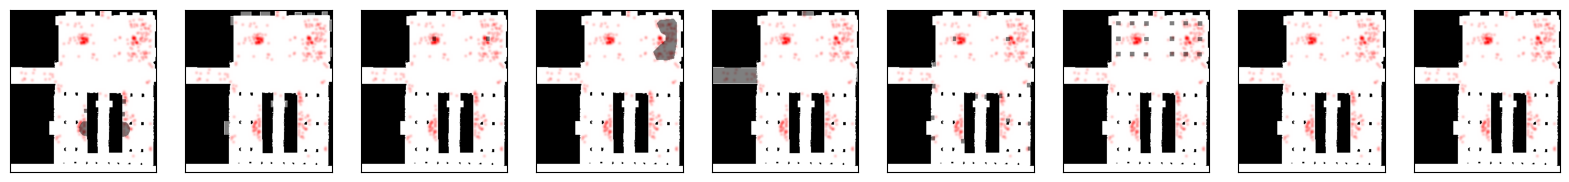

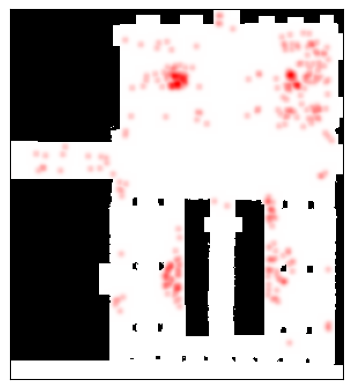

willow
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


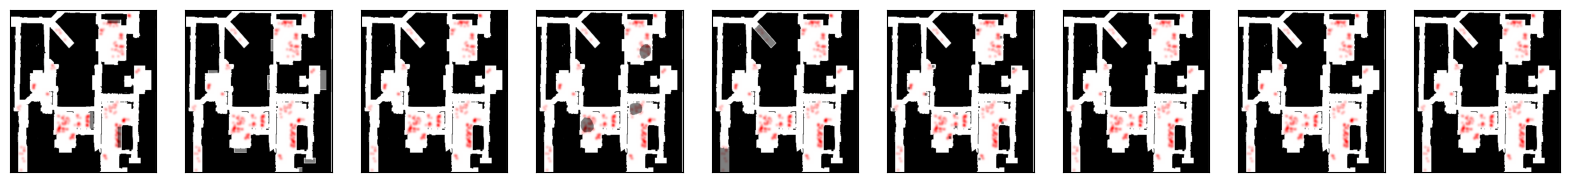

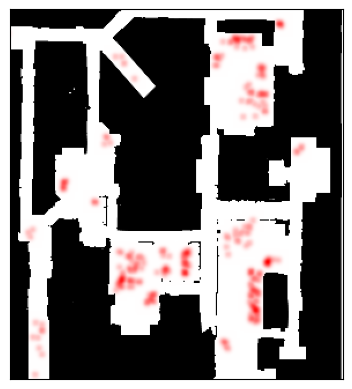

costacafe
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


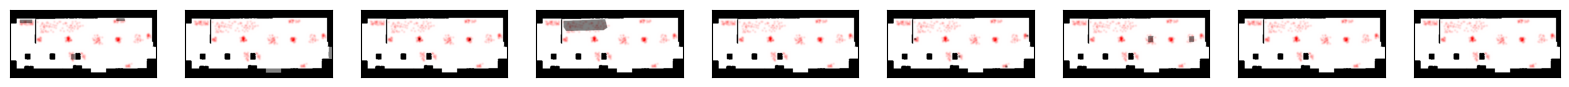

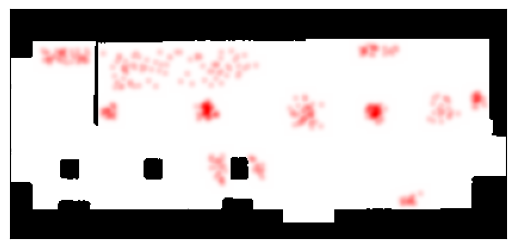

map1
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


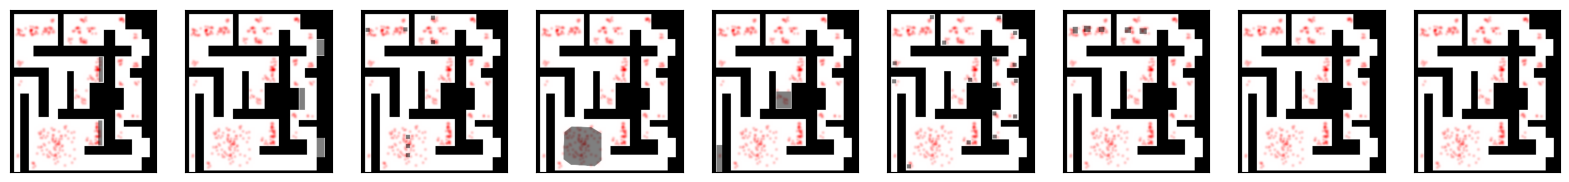

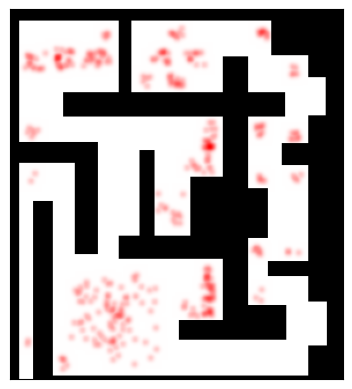

map2
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


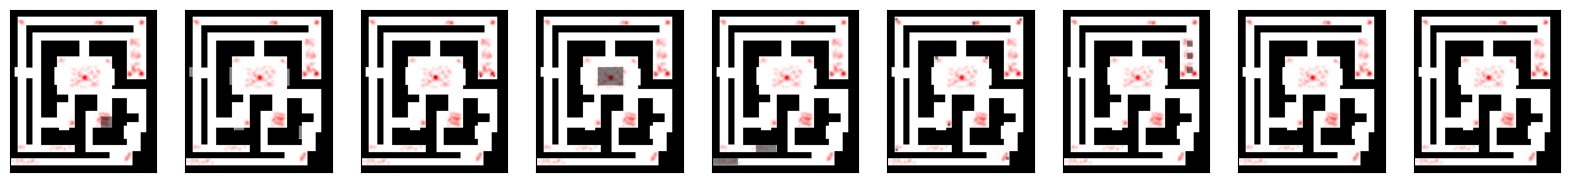

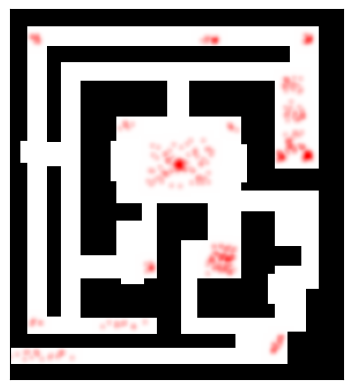

map3
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree', 'restricted', 'grass']


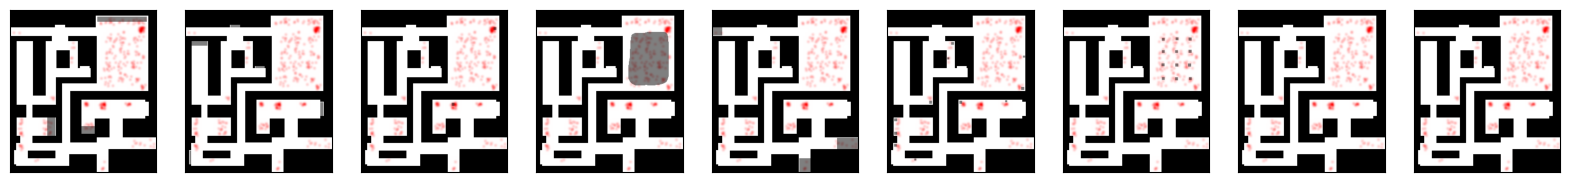

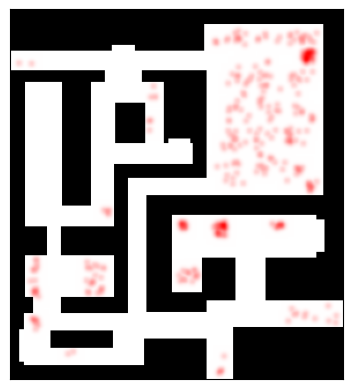

Mean KL-divergence: nan


In [20]:
kl1 = []

for map_count, map_name in enumerate(map_list):
  print(map_name)

  lines = 0
  with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
        lines = f.readlines()

      hh = len(lines)
      ww = len(lines[0].split(','))

      if hh != h or ww != w:
        print(f'h: {h}\tw: {w}')
        print(f'h: {hh}\tw: {ww}')
        raise SystemExit("ERROR: Different sizes!!")

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])

    except FileNotFoundError:
      for i in range(h):
        for j in range(w):
          map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red[map_count])),int(math.ceil(w/red[map_count])),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red[map_count],red[map_count]), np.max)
  h, w, _ = map.shape

  diff_h = int((h-div*int(h/div))/2)
  r_h = int((h-div*int(h/div))%2) + diff_h
  diff_w = int((w-div*int(w/div))/2)
  r_w = int((w-div*int(w/div))%2) + diff_w
  map = map[r_h:-diff_h:,r_w+diff_w:,:]

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-stop.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([float(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  sigma = 4.0
  data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
  data = skimage.measure.block_reduce(data, (red[map_count],red[map_count]), np.max)
  data = data[r_h:-diff_h,r_w+diff_w:]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    i = i+1
    ax = plt.subplot(1, len(sem_dict), i)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(data.shape,1),1-data,1-data),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # # -----------------------------------------------------------------------------------
  # # creating subplot and figure
  # ax = plt.subplot(111)
  # data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  # step = int(32/4)
  # for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
  #   c = int(i%(w/step+int(div/step-1))) - int(div/step-1)*0
  #   r = int(i/(w/step+int(div/step-1))) - int(div/step-1)*0
  #   submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
  #   subdata = model2.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
  #   subdata = np.squeeze(subdata,axis=0)
  #   data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-(data_pred),1-(data_pred)),axis=2)), vmin=0, vmax=1)
  # ax.get_xaxis().set_visible(False)
  # ax.get_yaxis().set_visible(False)
  # plt.show()

  # sigma = 2.0
  # data = skimage.filters.gaussian(data, sigma=(sigma, sigma), channel_axis=-1)
  # ax = plt.subplot(111)
  # ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)), vmin=0, vmax=1)
  # ax.get_xaxis().set_visible(False)
  # ax.get_yaxis().set_visible(False)
  # plt.show()

  # data = data/sum(sum(data))
  # data_pred = data_pred/sum(sum(data_pred))
  # kl = 0
  # for i in range(data.shape[0]):
  #     for j in range(data.shape[1]):
  #         if data[i,j] > 0 and data_pred[i,j] > 0:
  #             kl = kl + data[i,j]*math.log2(data[i,j]/data_pred[i,j])
  # print(f'KL-divergence: {kl}')
  # kl1 = np.append(kl1,kl)


print(f'Mean KL-divergence: {np.mean(kl1)}')